In [ ]:
!pip install transformers datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 981.0 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 8.7 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [ ]:
import torch, os
import pandas as pd
from transformers import pipeline, BertForSequenceClassification, BertTokenizerFast
from torch.utils.data import Dataset
import warnings
# Suppress warnings
warnings.filterwarnings('ignore')

In [ ]:
from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'
device

'cuda'

In [ ]:
import pandas as pd
import gdown

# File ID from the shared link
file_id = "1pRWhOfeUfYgPI7J84zqT8nrXLRFH2rg2"
download_url = f"https://drive.google.com/uc?id={file_id}"
output = "clean_train_dataset.csv"  # Name to save the file

# Download the file using gdown
gdown.download(download_url, output, quiet=False)

# Load the CSV into a pandas DataFrame
df = pd.read_csv(output)

# Display the first few rows of the DataFrame
print(df.head())

Downloading...
From (original): https://drive.google.com/uc?id=1pRWhOfeUfYgPI7J84zqT8nrXLRFH2rg2
From (redirected): https://drive.google.com/uc?id=1pRWhOfeUfYgPI7J84zqT8nrXLRFH2rg2&confirm=t&uuid=f7745f56-644b-4125-9ba9-d8d66a63c789
To: /content/clean_train_dataset.csv
100%|██████████| 301M/301M [00:06<00:00, 45.8MB/s]


                                                text    class
0  سرق ثلاثة لصوص لوحة من معرض باب القلعة سبانيا ...  Culture
1  كتبت مجلة فاريتي المريكية المتخصصة في الشون ال...  Culture
2  خبارنا المغربية متابعة توفي مسا الاحد بحد مستش...  Culture
3  رشيفية تجسد الزربية البجعدية التي تتميز بتناسق...  Culture
4  رشيفية يمنح فيلم سراب للمخرج المجري زابولكس ها...  Culture


In [ ]:
df_org = df_org.groupby('class').head(2500).reset_index(drop=True)

In [ ]:
# Randomize the rows
df_org = df_org.sample(frac=1).reset_index(drop=True)

In [ ]:
# Assuming df_org is your DataFrame
df_org = df_org[df_org['class'] != '.ipynb_checkpoints']

In [ ]:
labels = df_org['class'].unique().tolist()
labels = [s.strip() for s in labels ]
labels

['Culture', 'Finance', 'Politics', 'Sports', 'Religion', 'Tech', 'Medical']

In [ ]:
for key, value in enumerate(labels):
    print(value)

Culture
Finance
Politics
Sports
Religion
Tech
Medical


In [ ]:
NUM_LABELS= len(labels)

id2label={id:label for id,label in enumerate(labels)}

label2id={label:id for id,label in enumerate(labels)}

In [ ]:
label2id

{'Culture': 0,
 'Finance': 1,
 'Politics': 2,
 'Sports': 3,
 'Religion': 4,
 'Tech': 5,
 'Medical': 6}

In [ ]:
id2label

{0: 'Culture',
 1: 'Finance',
 2: 'Politics',
 3: 'Sports',
 4: 'Religion',
 5: 'Tech',
 6: 'Medical'}

In [ ]:
df_org.head()

,text,class
0,عبدالاله بوسحابة خبارنا المغربية بعد ثلاثة موا...,Culture
1,قال وزير السياحة السيد لحسن حداد ن سبانيا تشكل...,Finance
2,خبارنا المغربية عبد الرحيم القــاسمي فاز مصطفى...,Politics
3,الغابون تنفي دفع موال لميسي لزيارة علي بونغو ن...,Sports
4,خبارنا المغربية يسابق خبرا وزارة الداخلية الزم...,Politics


In [ ]:
df_org["labels"] = df_org["class"].map(lambda x: label2id[x.strip()])

In [ ]:
df_org.head()

,text,class,labels
0,عبدالاله بوسحابة خبارنا المغربية بعد ثلاثة موا...,Culture,0
1,قال وزير السياحة السيد لحسن حداد ن سبانيا تشكل...,Finance,1
2,خبارنا المغربية عبد الرحيم القــاسمي فاز مصطفى...,Politics,2
3,الغابون تنفي دفع موال لميسي لزيارة علي بونغو ن...,Sports,3
4,خبارنا المغربية يسابق خبرا وزارة الداخلية الزم...,Politics,2


In [ ]:
df_org.text[2]



'خبارنا المغربية عبد الرحيم القــاسمي فاز مصطفى الباكوري مرشح الصالة والمعاصرة ومينها العام براسة جهة الدار البيضا سطات بما مجموعه صوتا مقابل لمنافسه عبد الصمد حيكر عن العدالة والتنمية كما نجح مرشح حزب الصالة والمعاصرة لراسة جهة بني ملال خنيفرة براهيم مجاهد في الظفر بالمنصب بحيث نافس كلا من الاتحادي حازم الجيلالي و المهدي عثمون عن الحركة الشعبية وحسم حمد اخشيشن وكيل لاحة حزب الجرارراسة جهة مراكش لصالحه الى ذلك علنت سهيلة الريكي القيادي في حزب الصالة والمعاصرة فوز الياس العماري رسميا براسة جهة طنجة تطوان الحسيمة بغلبية صوتا من صل'

<Axes: ylabel='count'>

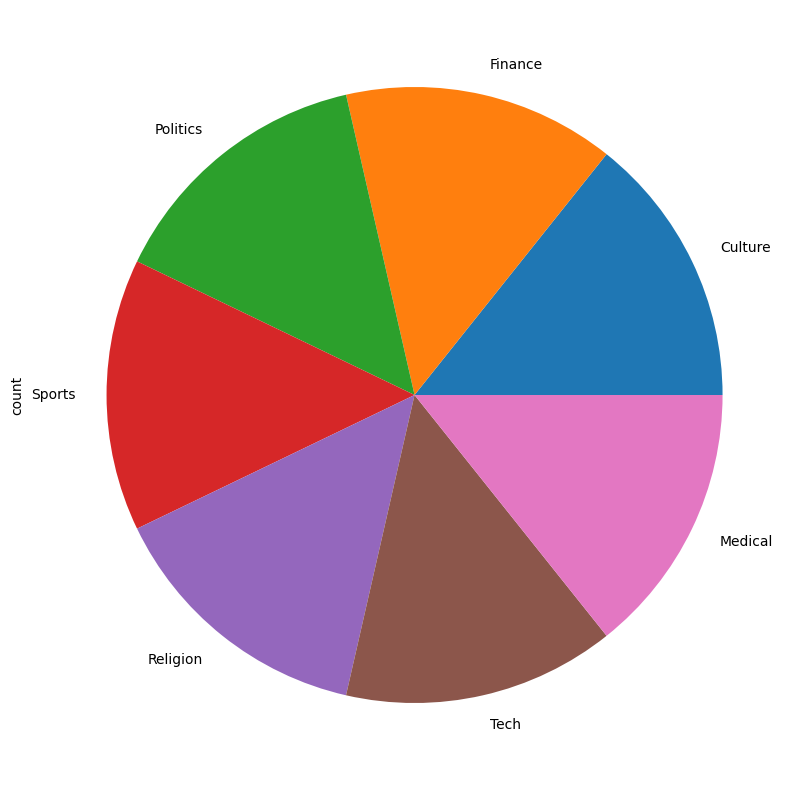

In [ ]:
df_org["class"].value_counts().plot(kind='pie', figsize=(10,10))

In [ ]:
tokenizer = BertTokenizerFast.from_pretrained("aubmindlab/bert-base-arabertv2", max_length=512)

tokenizer_config.json:   0%|          | 0.00/611 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/720k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.31M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/384 [00:00<?, ?B/s]

In [ ]:
model = BertForSequenceClassification.from_pretrained("aubmindlab/bert-base-arabertv2", num_labels=NUM_LABELS, id2label=id2label, label2id=label2id)
model.to(device)

model.safetensors:   0%|          | 0.00/543M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at aubmindlab/bert-base-arabertv2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(64000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

## Splitting df_org


In [ ]:
SIZE= df_org.shape[0]

train_texts= list(df_org.text[:SIZE//2])

val_texts=   list(df_org.text[SIZE//2:(3*SIZE)//4 ])

test_texts=  list(df_org.text[(3*SIZE)//4:])

train_labels= list(df_org.labels[:SIZE//2])

val_labels=   list(df_org.labels[SIZE//2:(3*SIZE)//4])

test_labels=  list(df_org.labels[(3*SIZE)//4:])

In [ ]:
len(train_texts)


8750

In [ ]:
len(train_texts), len(val_texts), len(test_texts)

(8750, 4375, 4375)

In [ ]:
train_texts = [str(text) for text in train_texts if text is not None]
val_texts = [str(text) for text in val_texts if text is not None]
test_texts = [str(text) for text in test_texts if text is not None]

train_encodings = tokenizer(train_texts, truncation=True, padding=True)
val_encodings  = tokenizer(val_texts, truncation=True, padding=True)
test_encodings = tokenizer(test_texts, truncation=True, padding=True)

In [ ]:
class DataLoader(Dataset):
    """
    Custom Dataset class for handling tokenized text data and corresponding labels.
    Inherits from torch.utils.data.Dataset.
    """
    def __init__(self, encodings, labels):
        """
        Initializes the DataLoader class with encodings and labels.

        Args:
            encodings (dict): A dictionary containing tokenized input text data
                              (e.g., 'input_ids', 'token_type_ids', 'attention_mask').
            labels (list): A list of integer labels for the input text data.
        """
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        """
        Returns a dictionary containing tokenized data and the corresponding label for a given index.

        Args:
            idx (int): The index of the data item to retrieve.

        Returns:
            item (dict): A dictionary containing the tokenized data and the corresponding label.
        """
        # Retrieve tokenized data for the given index
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        # Add the label for the given index to the item dictionary
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        """
        Returns the number of data items in the dataset.

        Returns:
            (int): The number of data items in the dataset.
        """
        return len(self.labels)


In [ ]:
train_dataloader = DataLoader(train_encodings, train_labels)

val_dataloader = DataLoader(val_encodings, val_labels)

test_dataset = DataLoader(test_encodings, test_labels)

## Training with Trainer Class

In [ ]:
from transformers import TrainingArguments, Trainer

In [ ]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def compute_metrics(pred):
    """
    Computes accuracy, F1, precision, and recall for a given set of predictions.

    Args:
        pred (obj): An object containing label_ids and predictions attributes.
            - label_ids (array-like): A 1D array of true class labels.
            - predictions (array-like): A 2D array where each row represents
              an observation, and each column represents the probability of
              that observation belonging to a certain class.

    Returns:
        dict: A dictionary containing the following metrics:
            - Accuracy (float): The proportion of correctly classified instances.
            - F1 (float): The macro F1 score, which is the harmonic mean of precision
              and recall. Macro averaging calculates the metric independently for
              each class and then takes the average.
            - Precision (float): The macro precision, which is the number of true
              positives divided by the sum of true positives and false positives.
            - Recall (float): The macro recall, which is the number of true positives
              divided by the sum of true positives and false negatives.
    """
    # Extract true labels from the input object
    labels = pred.label_ids

    # Obtain predicted class labels by finding the column index with the maximum probability
    preds = pred.predictions.argmax(-1)

    # Compute macro precision, recall, and F1 score using sklearn's precision_recall_fscore_support function
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='macro')

    # Calculate the accuracy score using sklearn's accuracy_score function
    acc = accuracy_score(labels, preds)

    # Return the computed metrics as a dictionary
    return {
        'Accuracy': acc,
        'F1': f1,
        'Precision': precision,
        'Recall': recall
    }


## compute_metrics



In [ ]:
!pip install wandb


In [ ]:
import wandb

# Replace with your actual API key
wandb.login(key="ea32ff9653605e0131e4d5ea5973da5de2a2987f")


wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: adilreda2014 (adilreda2014-universit-internationale-de-rabat). Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [ ]:
training_args = TrainingArguments(
    # The output directory where the model predictions and checkpoints will be written
    output_dir='./TTC4900Model',
    do_train=True,
    do_eval=True,
    # The number of epochs, defaults to 3.0
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    # Number of steps used for a linear warmup
    warmup_steps=100,
    weight_decay=0.01,
    logging_strategy='steps',
    # TensorBoard log directory
    logging_dir='./multi-class-logs',
    logging_steps=50,
    eval_strategy="steps",  # Updated to eval_strategy
    eval_steps=50,
    save_strategy="steps",
    fp16=True,
    load_best_model_at_end=True
)


In [ ]:
trainer = Trainer(
    # the pre-trained model that will be fine-tuned
    model=model,
     # training arguments that we defined above
    args=training_args,
    train_dataset=train_dataloader,
    eval_dataset=val_dataloader,
    compute_metrics= compute_metrics
)

In [ ]:
trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
50,1.714800,1.067531,0.791086,0.790632,0.859768,0.792214
100,0.652000,0.450146,0.880686,0.877722,0.889296,0.879367
150,0.467200,0.323540,0.911314,0.910712,0.914437,0.910086
200,0.307800,0.321173,0.902400,0.902986,0.912057,0.901875
250,0.336900,0.358575,0.904229,0.901881,0.915078,0.902649
300,0.313400,0.264222,0.924571,0.924764,0.928005,0.924226
350,0.260000,0.254110,0.930057,0.929701,0.931973,0.929307
400,0.265600,0.206189,0.939886,0.939557,0.940181,0.939862
450,0.284600,0.234694,0.933029,0.933130,0.935936,0.932432
500,0.319400,0.211709,0.938286,0.938001,0.939237,0.937767


TrainOutput(global_step=1641, training_loss=0.24775539063448443, metrics={'train_runtime': 1799.5805, 'train_samples_per_second': 14.587, 'train_steps_per_second': 0.912, 'total_flos': 6906975264000000.0, 'train_loss': 0.24775539063448443, 'epoch': 3.0})

In [ ]:
q=[trainer.evaluate(eval_dataset=df_org) for df_org in [train_dataloader, val_dataloader, test_dataset]]

pd.DataFrame(q, index=["train","val","test"]).iloc[:,:5]

,eval_loss,eval_Accuracy,eval_F1,eval_Precision,eval_Recall
train,0.102989,0.973486,0.973582,0.973639,0.973560
val,0.197008,0.947657,0.947506,0.947485,0.947568
test,0.221767,0.946057,0.945850,0.945865,0.945942


In [ ]:
from transformers import DistilBertForSequenceClassification, DistilBertTokenizerFast

In [ ]:
def predict(text):
    """
    Predicts the class label for a given input text

    Args:
        text (str): The input text for which the class label needs to be predicted.

    Returns:
        probs (torch.Tensor): Class probabilities for the input text.
        pred_label_idx (torch.Tensor): The index of the predicted class label.
        pred_label (str): The predicted class label.
    """
    # Tokenize the input text and move tensors to the GPU if available
    inputs = tokenizer(text, padding=True, truncation=True, max_length=512, return_tensors="pt").to("cuda")

    # Get model output (logits)
    outputs = model(**inputs)

    probs = outputs[0].softmax(1)
    """ Explanation outputs: The BERT model returns a tuple containing the output logits (and possibly other elements depending on the model configuration). In this case, the output logits are the first element in the tuple, which is why we access it using outputs[0].

    outputs[0]: This is a tensor containing the raw output logits for each class. The shape of the tensor is (batch_size, num_classes) where batch_size is the number of input samples (in this case, 1, as we are predicting for a single input text) and num_classes is the number of target classes.

    softmax(1): The softmax function is applied along dimension 1 (the class dimension) to convert the raw logits into class probabilities. Softmax normalizes the logits so that they sum to 1, making them interpretable as probabilities. """

    # Get the index of the class with the highest probability
    # argmax() finds the index of the maximum value in the tensor along a specified dimension.
    # By default, if no dimension is specified, it returns the index of the maximum value in the flattened tensor.
    pred_label_idx = probs.argmax()

    # Now map the predicted class index to the actual class label
    # Since pred_label_idx is a tensor containing a single value (the predicted class index),
    # the .item() method is used to extract the value as a scalar
    pred_label = model.config.id2label[pred_label_idx.item()]

    return probs, pred_label_idx, pred_label


In [ ]:
# Test with a an example text in Turkish
text = """خبارنا المغربية عبد الرحيم القــاسمي فاز مصطفى الباكوري مرشح الصالة والمعاصرة ومينها العام براسة جهة الدار البيضا سطات بما مجموعه صوتا مقابل لمنافسه عبد الصمد حيكر عن العدالة والتنمية كما نجح مرشح حزب الصالة والمعاصرة لراسة جهة بني ملال خنيفرة براهيم مجاهد في الظفر بالمنصب بحيث نافس كلا من الاتحادي حازم الجيلالي و المهدي عثمون عن الحركة الشعبية وحسم حمد اخشيشن وكيل لاحة حزب الجرارراسة جهة مراكش لصالحه الى ذلك علنت سهيلة الريكي القيادي في حزب الصالة والمعاصرة فوز الياس العماري رسميا براسة جهة طنجة تطوان الحسيمة بغلبية صوتا من صل"""
# "Machine Learning itself is moving towards more and more automated"
predict(text)

(tensor([[2.9728e-03, 1.1206e-02, 9.8442e-01, 3.6985e-04, 3.2895e-04, 3.2133e-04,
          3.8159e-04]], device='cuda:0', grad_fn=<SoftmaxBackward0>),
 tensor(2, device='cuda:0'),
 'Politics')

## Save model for inference

In [ ]:
model_path = "turkish-text-classification-model"
trainer.save_model(model_path)
tokenizer.save_pretrained(model_path)

('turkish-text-classification-model/tokenizer_config.json',
 'turkish-text-classification-model/special_tokens_map.json',
 'turkish-text-classification-model/vocab.txt',
 'turkish-text-classification-model/added_tokens.json',
 'turkish-text-classification-model/tokenizer.json')

## Re-Load saved model for inference

In [ ]:
model_path = "turkish-text-classification-model"


model = BertForSequenceClassification.from_pretrained(model_path)
tokenizer= BertTokenizerFast.from_pretrained(model_path)
nlp= pipeline("sentiment-analysis", model=model, tokenizer=tokenizer)

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.
